# Imports

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from scipy.sparse import hstack, csr_matrix
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize

# Load Dataset

In [2]:
data = pd.read_csv("twitter_training.csv", names=["Id","Entity","Sentiment","Text"])
data = data.drop("Id", axis=1)
data.head()

,Entity,Sentiment,Text
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Entity     74682 non-null  object
 1   Sentiment  74682 non-null  object
 2   Text       73996 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [4]:
data.isnull().sum()

Entity         0
Sentiment      0
Text         686
dtype: int64

# Fix Missing Values

In [5]:
data["Text"] = data["Text"].fillna(
    data["Entity"].apply(lambda x: f"{x} mentioned but no sentiment available")
)

In [6]:
data.isnull().sum()

Entity       0
Sentiment    0
Text         0
dtype: int64

# Encoding

In [7]:
data["Sentiment"] = data["Sentiment"].map({
    "Positive":3, "Neutral":2, "Negative":1, "Irrelevant":0
})

In [8]:
data.head()

,Entity,Sentiment,Text
0,Borderlands,3,im getting on borderlands and i will murder yo...
1,Borderlands,3,I am coming to the borders and I will kill you...
2,Borderlands,3,im getting on borderlands and i will kill you ...
3,Borderlands,3,im coming on borderlands and i will murder you...
4,Borderlands,3,im getting on borderlands 2 and i will murder ...


In [9]:
data["Entity"].nunique()

32

In [10]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
entity_encoded = ohe.fit_transform(data[["Entity"]])
x_entity = entity_encoded  

# Clean Text

In [55]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def process(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if w.isalpha() and w.lower() not in stop_words]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemmas)

data["Clean_Text"] = data["Text"].apply(process)

In [56]:
data.head()

,Entity,Sentiment,Text,Clean_Text
0,Borderlands,3,im getting on borderlands and i will murder yo...,im getting borderland murder
1,Borderlands,3,I am coming to the borders and I will kill you...,coming border kill
2,Borderlands,3,im getting on borderlands and i will kill you ...,im getting borderland kill
3,Borderlands,3,im coming on borderlands and i will murder you...,im coming borderland murder
4,Borderlands,3,im getting on borderlands 2 and i will murder ...,im getting borderland murder


# Vectorization

In [46]:
tfidf = TfidfVectorizer(max_features=20000)
x_text = tfidf.fit_transform(data["Clean_Text"])
x_text.shape

(74682, 20000)

In [14]:
x = hstack([x_text, x_entity])
y = data["Sentiment"]
x.shape,y.shape

((74682, 20032), (74682,))

# Train Test Split

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=69)
x_train.shape,y_train.shape

((59745, 20032), (59745,))

# Model Building and Evaluation

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

scores = {}
models = {
    "KNN":KNeighborsClassifier(3),
    "LR":LogisticRegression(max_iter=2000,solver="saga"), #suits for sparse matrix
    "DT":DecisionTreeClassifier(max_features=100),
    "SVM":LinearSVC()
}
for name,model in models.items():
    m = model.fit(x_train,y_train)
    pred = model.predict(x_test)
    scores[name] = accuracy_score(y_test,pred)
    print(name ,"=>",accuracy_score(y_test,pred))

KNN => 0.9144406507330789
LR => 0.7669545424114614
DT => 0.8087969471781482
SVM => 0.8337015464952802


In [26]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_train,y_train)
accuracy_score(y_test,model.predict(x_test))

0.9001138113409654

In [43]:
scores

{'KNN': 0.9144406507330789,
 'LR': 0.7669545424114614,
 'DT': 0.8087969471781482,
 'SVM': 0.8337015464952802}

C:\Users\User\AppData\Local\Temp\ipykernel_8164\638080197.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores.keys(),y=scores.values(),palette=colors,width=0.3)


Text(0.5, 1.0, 'Model Comparision')

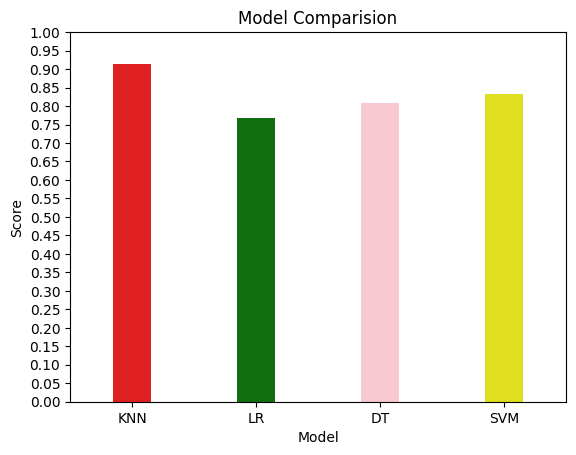

In [42]:
colors = ["red","green","pink","yellow"]
sns.barplot(x=scores.keys(),y=scores.values(),palette=colors,width=0.3)
ymin, ymax = plt.ylim()
plt.yticks(np.arange(ymin, ymax + 0.05, 0.05))
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Comparision")

# Confusion Matrix

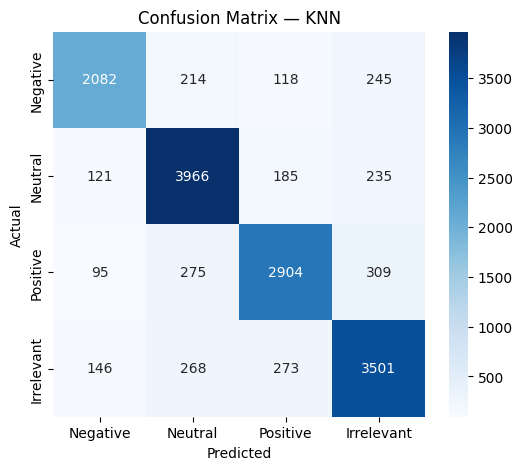

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, model.predict(x_test))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative","Neutral","Positive","Irrelevant"],
            yticklabels=["Negative","Neutral","Positive","Irrelevant"])
plt.title("Confusion Matrix — KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()